# Introduzione

Quanto segue è la realizzazione del progetto "House Prices Advanced Regression Techniques" prodotta da *Paolo Ciasco* & *Lorenzo Mancino*. Il work-flow deciso aprirà con un parte di feature engineering per poi testare vari modelli di apprendimento studiati all'interno del corso.
<!-- TBD -->



## Librerie Utilizzate

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Display multipli in fase di output

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate

## Dati a Disposizione

Essendo una competizione di Kaggle e non essendo il nostro scopo partecipare ad essa abbiamo dovuto sistemare i dati a disposizione affinché avessimo un dataset consistente e propedeutico al nostro scopo. I dati forniti da Kaggle, infatti, sono costruiti affinché tutte le persone possano concorrere su uno stesso testset con i target dello stesso inseriti in un ulteriore file .csv. Il nostro lavoro è stato di unire il train ed il testset (riportando i target nello stesso) per generare un unico dataset su cui ci concentreremo, inoltre, è stato eseguito un shuffling dello stesso per garantire eterogeneità dei dati.

In [ ]:
train_set = pd.read_csv("./train.csv") # Caricamento del trainset
test_set = pd.read_csv("./test.csv") # Caricamento del testset
target_set = pd.read_csv("./sample_submission.csv") # Caricamento del file ove sono presenti i target

#SalePrice = target_set.SalePrice # Selezione della colonna dei target
#test_set = test_set.join(SalePrice) # Immissione della colonna dei target nel testset
#test_set.to_csv('test.csv', index=False) # Sovrascrittura del testset con quello sistemato

# Unione del testset sistemato con il trainset

data_support = pd.read_csv('test.csv')
frames = [train_set, data_support]
final = pd.concat(frames)
final.to_csv('dataset.csv', index=False) # Export del file

# Caricamento del dataset ottenuto

data = pd.read_csv('dataset.csv')

# Shuffling del dataset

data = data.sample(frac = 1)


### Analisi Dei Dati

Viene effettuata ora un'analisi dei dati per vedere cosa abbiamo a disposizione per svolgere il task: fare regressione sul prezzo delle case.

Come prima cosa si mostra con quanti elementi stiamo lavorando ed il numero delle feature fornite.

In [ ]:
data.iloc[0:5, 0:5] # Porzione di dataframe

data.shape # Mostra le righe e le colonne del dataframe

data.iloc[1:3, 80:81] # Locazione del target

,Id,MSSubClass,MSZoning,LotFrontage,LotArea
744,745,120,RL,41.0,5395
2474,2475,70,RL,107.0,12888
775,776,120,RM,32.0,4500
549,550,60,FV,75.0,9375
1707,1708,20,FV,72.0,8640


(2919, 81)

,SalePrice
2474,185527.714878
775,162000.000000


Il dataset fornito raccoglie $2919$ elementi e $81$ feature (includendo anche il target come 81esima feature). I dati forniti, inoltre, forniscono un utilissimo file .txt che descrive rapidamente le feature utilizzate.

Non essendo il dataset eccessivamente popolato, sebbene non verranno usate Neural Network, si decide di sfruttare la k-fold validation.
Essendo le feature un numero veramente elevato per una regressione del prezzo di una casa si decide di attuare la cosidetta Feature Engineering. 

## Feature Engineering

Come prima cosa si controlla l'assenza completa di dati in eventuali colonne

In [ ]:
# Iterazione su tutte le colonne per controllare l'eventuale presenza di valori nulli su tutta l'intera colonna

for i in data.columns:
    if data[i].isnull().all():
        print(data[i])
    

Sfruttando la libreria *missingno* vogliamo mostrare una matrice di valori mancanti per trovare eventuali feature poco popolate su cui fare un'analisi ulteriore.

<AxesSubplot:>

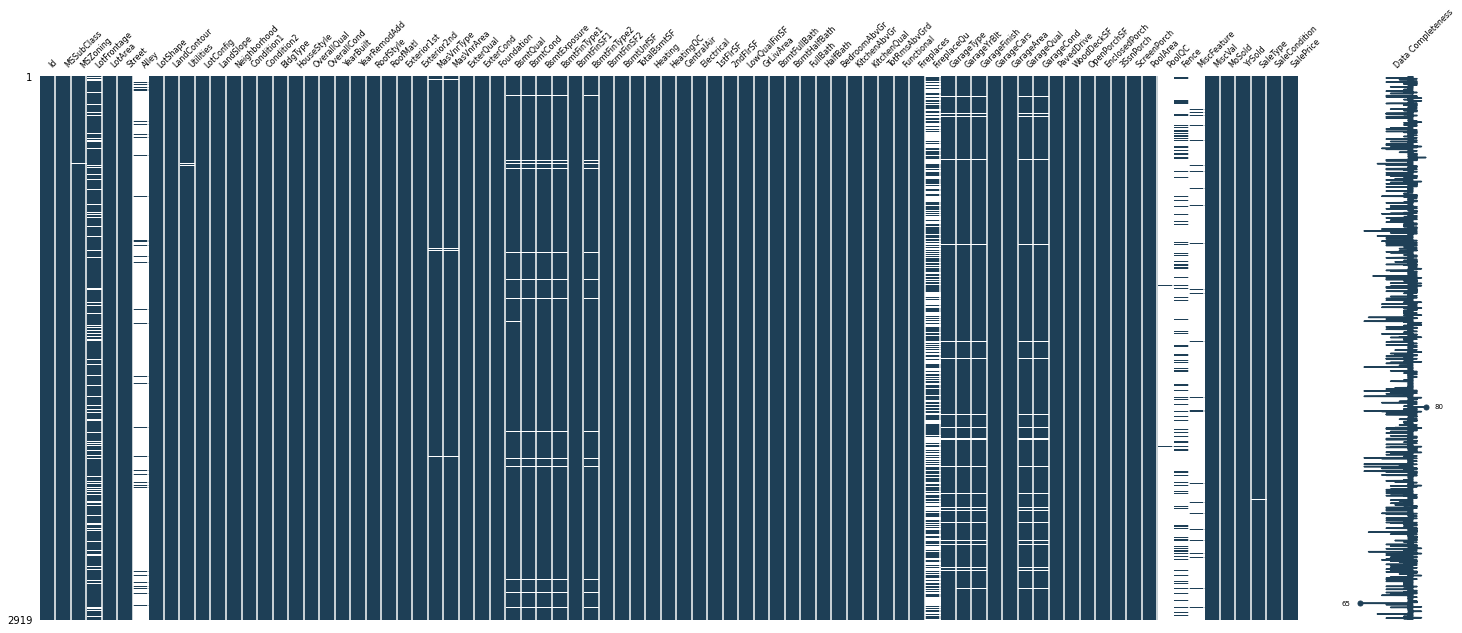

In [ ]:
msno.matrix(data, labels=True, fontsize=8, color = (0.12,0.25,0.34))


La prima feature che notiamo essere poco popolata è **Alley**, ovvero (seguendo le istruzioni fornite come specificato poco prima) la feature riguardante l'ingresso o meno da dei vicoli e, se presente, il materiale usato per lo stesso. In questo caso non è salutare eliminare direttamente la feature perché in realta i valori mancanti indicano il fatto che la casa non ha ingressi da vicoli che, in un ipotetico prezzo finale, è una caratteristica che è rilevante. Riguardo questo, utilizzeremo un metodo per "fillare" i valori nulli in modo tale che l'informazione venga preservata.

La seconda feature che coglie la nostra attenzione è **FireplaceQu**, ovvero la feature che esprime la qualità del camino se presente. Qui, a differenza di prima, ci annotiamo questa feature come potenzialmente "inutile" perchè ne è presente una ulteriore (**Fireplaces**) che descrive il numero di camini presenti nella casa. Sfrutteremo in seguito un'analisi di correlazione per confermare o meno questa ipotesi.

La terza feature che vediamo essere poco popolata è **PoolQC**, ovvero la feature che rappresenta la qualità della piscina se presente. Anche qui prendiamo nota della stessa perché risulta esserne presente un'altra (**PoolArea**) che esprime i metri quadri della piscina. Ulteriori analisi e ragionamenti in seguito all'analisi di correlazione.

La quarta feature interessante è **Fence**, ovvero la feature che esprime la presenza o meno di una recizione e, se presente,la sua qualità. Come nel primo caso non possiamo ragionare su questa feature in quanto la presenza di una recizione è sicuramente un elemento a favore o meno di un prezzo.

L'ultima feature è **MiscFeature**, ovvero la feature che descrive elementi addizionali di una casa(ad es. Ascensore, Campo da Tennis, ...). Prendiamo nota di questa feature in quanto è presente una ulteriore feature (**MiscVal**) che esprime il valore totale di tutti gli elementi addizionali presenti. Anche qui verranno eseguite ulteriori analisi.


### Data Processing

Cominciamo a lavorare sul dataset partendo dal preprocessing dei dati.
E' necessaria una piccola digressione su come possono essere presentate le feature. 

Si distinguono feature **categoriche** (ovvero che sono espresse tramite stringhe) da quelle numeriche ed a loro volta le stesse si dividono in categoriche **nominali** (non sensibili all'ordinamento) e categoriche **ordinali**. 

Il nostro obiettivo è quello di trasformare tutte le feature categoriche in numeriche affinché il modello abbia dati in ingresso omogenei e che sia da noi possibile confrontare le feature tra loro per scovare eventuali correlazioni o altro.\
Viene presentato ora un esempio di feature categorica **nominale** che indica la classificazione dell'immobile in base alla zona dove risiede:

In [ ]:
data["MSZoning"]

2700    RL
2121    RM
2132    RM
1931    RL
827     RL
        ..
2487    RL
1669    RL
49      RL
2675    RL
2496    RL
Name: MSZoning, Length: 2919, dtype: object

Viene ora presentato, invece, un esempio di feature categorica **ordinale** che indica la qualità dei materiali della casa da un minimo di 1 a un massimo di 10:

In [ ]:
data["OverallQual"]

0       7
1       6
2       7
3       7
4       8
       ..
2914    4
2915    4
2916    5
2917    5
2918    7
Name: OverallQual, Length: 2919, dtype: int64

Quanto segue è la trasformazione di tutti i valori delle feature del dataset in numeri e, contemporaneamente, gestione dei valori nulli(NaN) del dataset; sfrutteremo il **Label Encoder** andando a sovrascrivere i valori della colonna della feature selezionata con i nuovi valori. 

In 'data_description.txt' viene descritta per ogni feature categorica ordinale la scala di valutazione. Ad esempio la feature "ExterQual" assume i seguenti valori:

* Ex:	Excellent
* Gd:	Good
* TA:	Average/Typical
* Fa:	Fair
* Po:	Poor

Per queste feature "particolari" è buon uso mantenere l'ordine nel momento in cui i valori vengono trasformati. Ad esempio, siano $x_1$ e $x_2$ due possibili valori della stessa feature e siano $x'_1$ e $x'_2$ i valori trasformati; se $x_1 > x_2$ allora $x'_1 > x'_2$.

Per mantenere questa proprietà è stato utilizzato un dizionario, uno per ogni possibile scala.

Il Label Encoder fornisce una codifica univoca per ogni colonna di feature. \
L'idea è quella di quella di riempire tutti i valori nulli con una stringa speciale "0000" e di assegnargli valore 0 sia nelle categoriche ordinali che nominali. Per quanto riguarda le colonne che ospitavano degli interi faremo una sostituzione finale sostituendo la stringa "0000" in tutto il dataset con uno 0.

In questo modo abbiamo gestito sia i valori nulli del dataset che le feature categoriche.

In [ ]:
%%capture 

# Definizione delle feature categoriche nominali per richiamarle poi nel ciclo for

categorical_nominal_features = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig",
                                "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
                                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                                "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical",
                                "Functional", "GarageType", "PavedDrive", "MiscFeature", "SaleType",
                                "SaleCondition"]

# Definizione delle feature categoriche ordinali per richiamarle poi nel ciclo for

categorical_ordinal_features = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual",
    "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish", "Fence"
]

# Scrittura delle scale differenti presenti nel dataset(prese dalla descrizione dei dati)

quality_scale_dict = {"0000":0, "NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
BstmExposure_dict = {"0000":0, "NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
BsmtFinType_dict = {"0000":0, "NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
GarageFinish_dict = {"0000":0, "NA": 0, "Unf": 1, "RFn": 2, "Fin": 3}
Fence_dict = {"0000":0, "NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}

# Assegnazione delle scale alle feature(secondo la descrizione dei dati)

feature_scale_dict = {
    "ExterQual": quality_scale_dict,
    "ExterCond": quality_scale_dict,
    "BsmtQual": quality_scale_dict,
    "BsmtCond": quality_scale_dict,
    "HeatingQC": quality_scale_dict,
    "KitchenQual": quality_scale_dict,
    "FireplaceQu": quality_scale_dict,
    "GarageQual": quality_scale_dict,
    "GarageCond": quality_scale_dict,
    "PoolQC": quality_scale_dict,
    "BsmtExposure": BstmExposure_dict,
    "BsmtFinType1": BsmtFinType_dict,
    "BsmtFinType2": BsmtFinType_dict,
    "GarageFinish": GarageFinish_dict,
    "Fence": Fence_dict
}

data.fillna("0000", inplace=True) # Replace dei valori nulli con una stringa speciale che non è presente nel dataset

# Trasformazione tramite LabelEncoder delle feature categoriche nominali

le = LabelEncoder()

for feature in categorical_nominal_features:
    le.fit(data[feature])
    data[feature] = le.transform(data[feature])

# Trasformazione tramite apply rispetto il dizionario prima creato

for feature in categorical_ordinal_features:
    dict = feature_scale_dict[feature]
    data[feature] = data[feature].apply(lambda x: dict[x])


data.replace("0000", 0, inplace=True) # Replace finale per gestire colonne dove sono finite le stringhe speciali



### Modelli pre-feature engineering

In questa sezione verranno mostrati i risultati dei seguenti modelli(tramite 5-fold cross validation) sulle feature non ingegnerizzate:
- Linear Regression (baseline)
- Decision Tree
- Begging
- Gradient Boosting
- Random Forest
- KNN (non-parametric)

L'obiettivo sarà quello di confrontare l'evoluzione dei risultati post elaborazione delle feature.

Il primo passo è quello di separare il target dal dataset e poi impostare il numero di fold che verranno eseguiti nell'intero codice.

In [ ]:
# Separazione del target dal dataset

X_data = data.drop(["SalePrice"], axis=1) # Drop dalle colonne
Y_data = data["SalePrice"].values

# Setting dei k fold

folds = KFold(n_splits = 5, shuffle = True, random_state = 98)


Iniziano ora le predizioni dei modelli sopra descritti.

È bene specificare che per i modelli i quali necessitavano di parametri fondamentali per la buona riuscita del task (come ad esempio la profondità massima in un albero di decisione) è stata usata una libreria (**GridSearchCV**) per svolgere una ricerca esaustiva (sempre in cross validation con lo stesso k) degli stessi, propedeutica a stabilirne i migliori possibili.

Sono inoltre forniti dei grafici per carpire l'andamento delle predizioni nei differenti modelli.

##### Linear Regression

Text(0.5, 0, 'Measured')

Text(0, 0.5, 'Predicted')

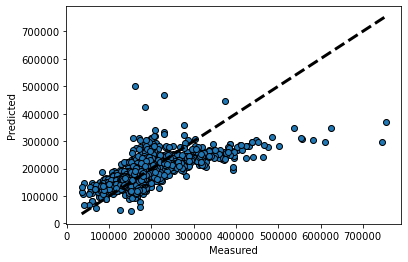

Score :  0.45884214917374083


In [ ]:
model1 = LinearRegression()
scores = cross_val_score(model1, X_data, Y_data, scoring='r2', cv=folds)
lin_predict = cross_val_predict(model1, X_data, Y_data, cv=5)

# Plot 

fig,  ax = plt.subplots()
ax.scatter(Y_data, lin_predict, edgecolors=(0,0,0))
ax.plot([Y_data.min(), Y_data.max()], [Y_data.min(), Y_data.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#####

avg_score = np.mean(scores)
print ("Score : " , avg_score)


##### Decision Tree

Per quanto riguarda gli alberi di decisione decidiamo di usare le cross-fold validation tramite GridSearch per trovare l'iperparametro migliore per quanto riguarda la massima profondità degli stessi.

In [ ]:
params = {'max_depth': list(range(2,30))}
gscv = GridSearchCV(DecisionTreeRegressor(random_state = 42), params, verbose=1, cv = folds)

gscv.fit(X_data, Y_data)

gscv.best_estimator_


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=98, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29]},
             verbose=1)

DecisionTreeRegressor(max_depth=9, random_state=42)

Text(0.5, 0, 'Measured')

Text(0, 0.5, 'Predicted')

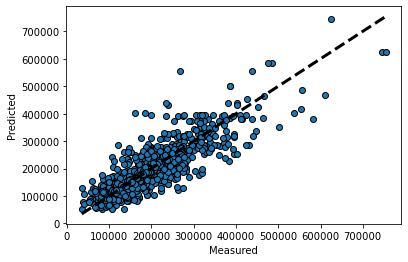

Score :  0.7326921869104969


In [ ]:
dt = DecisionTreeRegressor(random_state=42, max_depth=16, criterion='mse')

dt_scores = cross_val_score(dt, X_data, Y_data, cv=folds)
lin2_predict = cross_val_predict(dt, X_data, Y_data, cv=folds)


# Plot 

fig,  ax = plt.subplots()
ax.scatter(Y_data, lin2_predict, edgecolors=(0,0,0))
ax.plot([Y_data.min(), Y_data.max()], [Y_data.min(), Y_data.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#####

avg_score_dt = np.mean(dt_scores)
print ("Score : " , avg_score_dt)


##### Bagging

In [ ]:
params1 = {'n_estimators': list(range(2,50))}
gscv1 = GridSearchCV(BaggingRegressor(random_state = 42), params1, verbose=1, cv = folds)

gscv1.fit(X_data, Y_data)

gscv1.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=98, shuffle=True),
             estimator=BaggingRegressor(random_state=42),
             param_grid={'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30,
                                          31, ...]},
             verbose=1)

BaggingRegressor(n_estimators=45, random_state=42)

Text(0.5, 0, 'Measured')

Text(0, 0.5, 'Predicted')

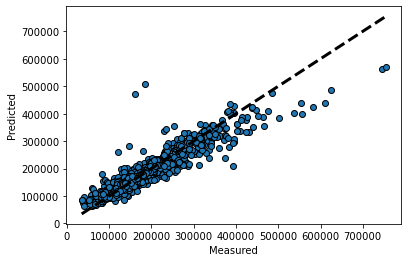

Score :  0.8695609611655503


In [ ]:
bag_regr = BaggingRegressor(random_state=42, n_estimators=45)
bag_regr_scores = cross_val_score(bag_regr, X_data, Y_data, cv=folds)
bag_regr_val = cross_val_predict(bag_regr, X_data, Y_data, cv=folds)


# Plot 

fig,  ax = plt.subplots()
ax.scatter(Y_data, bag_regr_val, edgecolors=(0,0,0))
ax.plot([Y_data.min(), Y_data.max()], [Y_data.min(), Y_data.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#####

avg_score_bag_regr = np.mean(bag_regr_scores)
print("Score : " ,avg_score_bag_regr)

##### Gradient Boosting

In [ ]:
scores = []
r = range(1,100)
for k in r:
    score = cross_val_score(estimator=GradientBoostingRegressor(n_estimators=k), X = X_data, y= Y_data, cv=folds)
    scores.append(score.mean())


Text(0.5, 0, 'Numero di stimatori')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Score al variare del numero di stimatori')

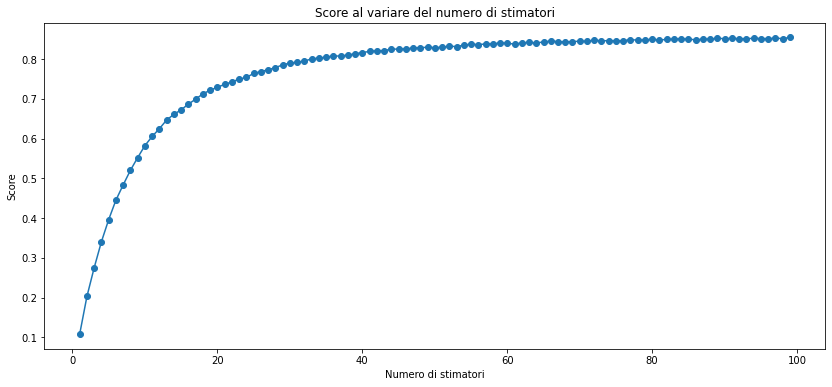

In [ ]:
fig = plt.figure(figsize=(14,6))
ax = fig.gca()
plt.plot(r, scores, marker='o') 
plt.xlabel(r'Numero di stimatori')
plt.ylabel('Score')
plt.title(r'Score al variare del numero di stimatori')
plt.show()

In [ ]:
grad_regr = GradientBoostingRegressor(random_state=42, n_estimators=50)
grad_regr_scores = cross_val_score(grad_regr, X_data, Y_data, cv=folds)
grad_regr_pred = cross_val_predict(grad_regr, X_data, Y_data, cv=folds)

avg_score_grad_regr = np.mean(grad_regr_scores)
memoryGR = avg_score_grad_regr
print("Score : ", avg_score_grad_regr)

Score :  0.8225499122620873


##### Random Forest

In [ ]:
scores = []
r = range(1,100)
for k in r:
    score = cross_val_score(estimator=RandomForestRegressor(n_estimators=k), X = X_data, y= Y_data, cv=folds)
    scores.append(score.mean())


Text(0.5, 0, 'Numero di stimatori')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Score al variare del numero di stimatori')

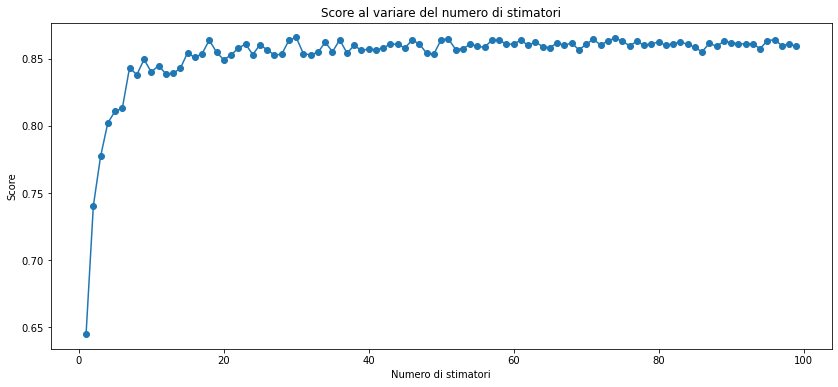

In [ ]:
fig = plt.figure(figsize=(14,6))
ax = fig.gca()
plt.plot(r, scores, marker='o') 
plt.xlabel(r'Numero di stimatori')
plt.ylabel('Score')
plt.title(r'Score al variare del numero di stimatori')
plt.show()

In [ ]:
forest_regr = RandomForestRegressor(random_state=42, n_estimators=25)
forest_regr_scores = cross_val_score(forest_regr, X_data, Y_data, cv=folds)
forest_regr_pred = cross_val_predict(forest_regr, X_data, Y_data, cv=folds)

avg_score_forest_regr = np.mean(forest_regr_scores)
memoryRF = avg_score_forest_regr
print("Score : ", avg_score_forest_regr)

Score :  0.8579967940623094


##### K Nearest Neighbors

In [ ]:
scores = []
r = range(1,15)
for k in r:
    score = cross_val_score(estimator=KNeighborsRegressor(n_neighbors=k), X = X_data, y= Y_data, cv=folds)
    scores.append(score.mean())

Text(0.5, 0, 'Numero di vicini')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Score al variare del numero di vicini')

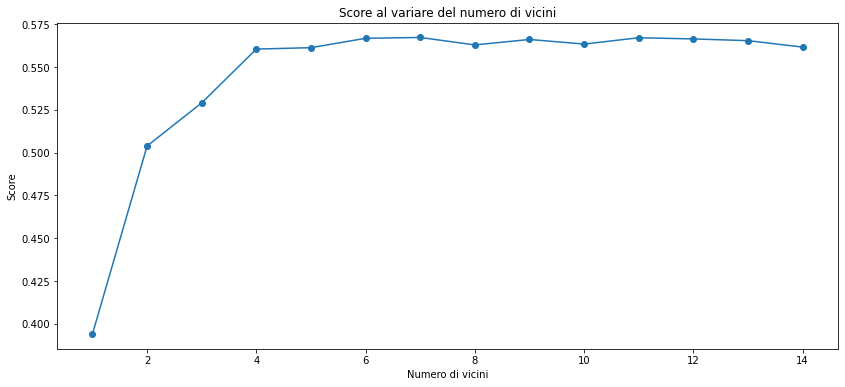

In [ ]:
fig = plt.figure(figsize=(14,6))
ax = fig.gca()
plt.plot(r, scores, marker='o') 
plt.xlabel(r'Numero di vicini')
plt.ylabel('Score')
plt.title(r'Score al variare del numero di vicini')
plt.show()

In [ ]:
knn_regr = KNeighborsRegressor(n_neighbors=5)
knn_regr_scores = cross_val_score(knn_regr, X_data, Y_data, cv=folds)
knn_regr_pred = cross_val_predict(knn_regr, X_data, Y_data, cv=folds)

avg_score_knn_regr = np.mean(knn_regr_scores)
print("Score : ", avg_score_knn_regr)

Score :  0.5746051789481946


# Feature Selection: metodi di filter

## Correlazione tra feature

In questa parte faremo un'analisi rispetto alla correlazione tra feature per trovarne di eventuali collimabili.

Questa analisi fa parte di quei metodi chiamati **filter**. Sono metodi molto veloci ed **indipendenti** dal modello che sono utili per rimuovere features duplicate, correlate e ridondanti.

L'idea è quella di creare una matrice di correlazione tramite il coefficiente di **Spearman**(analizza la relazione monotonica di due variabili anche se la stessa è non lineare) ed impostare una certa soglia affinché le feature sopra la stessa possano essere contratte secondo qualche logica.



Dopo un'analisi qualitativa di quale soglia utilizzare si conviene di utilizzare $0.80$ come margine minimo di attenzione sul quale indagare poi sui dati.

In [ ]:

corr = data.corr(method="spearman") # Creazione della matrice di correlazione
corr.style.background_gradient(cmap='coolwarm').to_html('Correlation.html') # Export della matrice di correlazione


soglia0 = .60
soglia1 = .70
soglia2 = .80
soglia3 = .90
     
# Ricerca di valori maggiori di una certa soglia rispetto la matrice

#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia0)) if i < j]
#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia1)) if i < j]
[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia2)) if i < j]
#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia3)) if i < j]


['YearBuilt and GarageYrBlt',
 'Exterior1st and Exterior2nd',
 'BsmtFinType1 and BsmtFinSF1',
 'BsmtFinType2 and BsmtFinSF2',
 'TotalBsmtSF and 1stFlrSF',
 'GrLivArea and TotRmsAbvGrd',
 'Fireplaces and FireplaceQu',
 'GarageCars and GarageArea',
 'PoolArea and PoolQC',
 'MiscFeature and MiscVal']

Le due feature **YearBuilt** e **GarageYrBlt** sono decisamente collimabili a favore della prima, nella maggior parte dei casi ci si aspetta che il garage sia stato costruito lo stesso anno della casa e comunque, anche se così non fosse, non è una situazione che fornisce peso importante al prezzo finale di vendita.

In [ ]:
data.drop("GarageYrBlt", inplace=True, axis = 1)

Le due feature **Exterior1st** e **Exterior2nd** sono collimabili a favore della prima: è molto difficile che ci sia un secondo materiale specifico ricoprente la casa che rivesta una percentuale degna di nota ed in ogni caso esso non impatterebbe in modo rilevante sul prezzo finale di vendita.

In [ ]:
data.drop("Exterior2nd", inplace=True, axis = 1)

Le due feature **GrLivArea** e **TotRmsAbvGrd** sono decisamente collimabili a favore della prima: non è tanto importante il numero di camere(seconda) quanto il quantitativo di metri quadri(dal livello 0 in su) quando stiamo parlando di prezzo.

In [ ]:
data.drop("TotRmsAbvGrd", axis=1, inplace=True)

Le due feature **Fireplaces** e **FireplaceQu** sono collimabili a favore della seconda: se esiste un camino(o più) nella casa sarà espresso dalla seconda feature che contiene anche informazioni sulla qualità dello stesso e sulla presenza/assenza.

In [ ]:
data.drop("Fireplaces", inplace=True, axis=1)

Le due feature **GarageArea** e **GarageCars** sono decisamente collimabili a favore della prima: è più rilevante di quanti metri quadri sia il posto auto interno alla casa che la capacità di macchine che può ospitare.

In [ ]:
data.drop("GarageCars", inplace=True, axis=1)

Per le due feature **PoolArea** e **PoolQC** vale, in un certo senso, lo stesso discorso fatto per **Fireplaces**: la seconda ha già le informazioni che servono per la predizione finale. Collimiamo a favore di **PoolQC**.

In [ ]:
data.drop("PoolArea", inplace=True, axis=1)

Le due feature **MiscFeature** e **MiscVal** sono decisamente collimabili a favore della seconda in quanto rispecchia una somma di tutte le addizionalità presenti in una casa tramite il valore totale in dollari ed è quello che ci interessa a favore del prezzo finale.

In [ ]:
data.drop("MiscFeature", inplace=True, axis=1)

Rispetto le feature rimanenti (**BsmtFinType1**, **BsmtFinSF1**, **BsmtFinType2**, **BsmtFinSF2**, **TotalBsmtSF** e **1stFlrSF**) ci premiamo di esaminarle in ulteriori analisi a posteriori in quanto la decisione di come agire potrebbe essere deleteria rispetto alla predizione finale del prezzo di vendita.

Vengono ora mostrate le predizioni post cut delle feature indicate tramite i modelli che hanno perfomato meglio: **Random Forest** e **Gradient Boosting**.

In [ ]:
X_data = data.drop(["SalePrice"], axis=1) # Ricaricare il trainset aggiornato

In [ ]:
forest_regr = RandomForestRegressor(random_state=42, n_estimators=25)
forest_regr_scores = cross_val_score(forest_regr, X_data, Y_data, cv=folds)
forest_regr_pred = cross_val_predict(forest_regr, X_data, Y_data, cv=folds)

avg_score_forest_regr = np.mean(forest_regr_scores)
print("Score : ", avg_score_forest_regr)
print("Score before : ", memoryRF)

Score :  0.8571531486462114
Score before :  0.8579967940623094


In [ ]:
grad_regr = GradientBoostingRegressor(random_state=42, n_estimators=50)
grad_regr_scores = cross_val_score(grad_regr, X_data, Y_data, cv=folds)
grad_regr_pred = cross_val_predict(grad_regr, X_data, Y_data, cv=folds)

avg_score_grad_regr = np.mean(grad_regr_scores)
print("Score : ", avg_score_grad_regr)
print("Score before : ", memoryGR)

Score :  0.8263454645507986
Score before :  0.8225499122620873


La rimozioni di feature non ha impattato in maniera rilevante le performance dei migliori predittori trovati perciò viene ritenuta soddisfacente l'attività di filtering.

# Features Selection: wrapper methods

I metodi di **wrapper** permettono di valutare sottoinsiemi di feature esaminando come uno specifico modello si comporta utilizzando solo quel sottoinsieme di features.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Feature_selection_Wrapper_Method.png" 
        alt="Picture"
        style="display: block; margin: 0 auto" />


Per trovare il miglior sottoinsieme di features ad ogni iterazione viene valutato il modello scelto dopo averlo addestrato con un certo sottoinsieme di features utilizzando la cross validation. Il modo in cui viene scelto il sottoinsieme dipende dalla strategia utilizzata.

Questo approccio di feature selection è molto più lento rispetto ai metodi di filters ma permette di esaminare le features in modo più approfondito.

Dato che si hanno $2^{|V|}$ possibili sottoinsiemi, dove $V$ è l'insieme delle features, risulta impraticabile effettuare una ricerca esaustiva, per questo motivo vengono applicate diverse strategie di ricerca per individuare il miglior sottoinsieme. 

Nel nostro caso andremo ad esaminare le seguenti:


*   **Sequential Feature Selection** (SFS)
*   **Recursive Feature Elimination** (RFE)

## SFS:
A partire da un sottoinsieme di feature utilizza l'hill climbing (approccio greedy in cui vengono fatte scelte locali per ottimizzare lo score) per individuare il sottoinsieme successivo.

Ad ogni iterazione addestra e valuta il modello su ogni possibile sottoinsieme contenente le feature già selezionate e una nuova feature. Viene scelto il sottoinsieme su cui il modello ha ottenuto uno score migliore.

Questa viene anche detta **Sequential Forward Selection**; è presente anche la versione **backward** in cui si parte dall'insieme di tutte le feature e ad ogni iterazione viene rimossa la peggiore.

## RFE:
Questo approccio rimuove le features che impattano meno sul risultato finale finchè non si raggiunge un certo numero voluto. Questo viene fatto andando ad addestrare il modello scelto e creando un **ranking** delle features per importanza, selezionando, appunto, le più importanti e ri-addestrando il modello su di esse. Il rank può essere ottenuto utilizzando il modello selezionato (ad esempio nel caso degli alberi decisionali) oppure utilizzando metodi statistici, in alternativa può essere definito a priori. 

**RFE** è quindi un algoritmo di selezione di tipo wrapper ma che utilizza internamente anche filter-based feature selection.

## Obiettivo
L'obiettivo è quello di applicare questi due approcci sui modelli scelti in analisi e vedere come lo score dei modelli cambia in base alle features scelte da questi due algoritmi.

Per prima cosa introduciamo alcune funzioni d'utilità.

## Implementazione del codice

In [ ]:
# restituisce una barra che rappresenta i progressi fatti sotto forma di stringa
def progress_bar(i, n, len=20, comment=''):
    s = "["

    n = max(1, n)
    i = max(0, i)
    i = min(i, n)

    q = i / n
    done = int(len * q)
    s += "=" * (done)

    if (done != len):
        s += ">"

    s += "-" * (len - done - 1)
    s += "] " + str(i) + "/" + str(n) + " " + comment

    return s

# premette di stampare una stringa che può essere sovrascritta
# usata in combinazione con progress_bar() per visionare lo stato del processo
def print_deletable_line(s):
    print("\r" + s, end="")

# prende in input i dati ottenuti dalle analisi del modello utilizzando i vari approcci e li plotta su un grafo
def plot_data(cv_scores_sfs, cv_scores_rfe, best_score, title=''):
    r2_scores_sfs = cv_scores_sfs['r2']
    max_error_sfs = cv_scores_sfs['max_error']

    r2_scores_rfe = cv_scores_rfe['r2']
    max_error_rfe = cv_scores_rfe['max_error']

    X_axis = range(1, len(r2_scores_sfs) + 1)
    top_k_sfs = np.argmax(r2_scores_sfs) + 1
    top_k_rfe = np.argmax(r2_scores_rfe) + 1

    top_k_sfs_error = np.argmin(max_error_sfs) + 1
    top_k_rfe_error = np.argmin(max_error_rfe) + 1

    print("\nBest results:")
    print("\tbest scores sfs: (top features: " + str(top_k_sfs) + ", r2: " + str(r2_scores_sfs[top_k_sfs - 1]) +
            "); (top features: " + str(top_k_sfs_error) + ", max_error: " + str(max_error_sfs[top_k_sfs_error - 1]) + ")")
    print("\tbest scores rfe: (top features: " + str(top_k_rfe) + ", r2: " + str(r2_scores_rfe[top_k_rfe - 1]) +
          "); (top features: " + str(top_k_rfe_error) + ", max_error: " + str(max_error_sfs[top_k_rfe_error - 1]) + ")")

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(13, 5)
    fig.suptitle(title)

    ax[0].plot(X_axis, r2_scores_sfs, label='sfs', color='0')
    ax[0].plot(X_axis, r2_scores_rfe, label='rfe', color='r')

    ax[0].axhline(best_score, color='#A0A0A0', label='best_score')

    x, y = top_k_sfs, r2_scores_sfs[top_k_sfs - 1]
    ax[0].scatter([x], [y], color='0', s=20)
    ax[0].annotate("{:.3f}".format(y), (x, y), textcoords="offset points", xytext=(0, 15), ha='center', arrowprops= {"arrowstyle": "->", "color": 'black'})

    x, y = top_k_rfe, r2_scores_sfs[top_k_rfe - 1]
    ax[0].scatter([top_k_rfe], [r2_scores_rfe[top_k_rfe - 1]], color='r', s=20)
    ax[0].annotate("{:.3f}".format(y), (x, y), textcoords="offset points", xytext=(0, -20), ha='center', arrowprops={"arrowstyle": "->", "color": 'red'})


    ax[1].plot(X_axis, max_error_sfs, label='sfs', color='0')
    x, y = top_k_sfs_error, max_error_sfs[top_k_sfs_error - 1]
    ax[1].scatter([x], [y], color='0', s=20)
    ax[1].annotate("{:.0f}".format(y), (x, y), textcoords="offset points", xytext=(0, 15), ha='center', arrowprops={"arrowstyle": "->", "color": 'black'})

    ax[1].plot(X_axis, max_error_rfe, label='rfe', color='r')
    x, y = top_k_rfe_error, max_error_rfe[top_k_rfe_error - 1]
    ax[1].scatter([x], [y], color='r', s=20)
    ax[1].annotate("{:.0f}".format(y), (x, y), textcoords="offset points", xytext=(0, -20), ha='center', arrowprops={"arrowstyle": "->", "color": 'red'})

    ax[0].legend()
    ax[1].legend()

    ax[0].set_xlabel("top k features usate")
    ax[1].set_xlabel("top k features usate")

    ax[0].set_ylabel("r2 score")
    ax[1].set_ylabel("max_error score")

    plt.show()

Per ogni modello verrà utilizzata la **Sequential Forward Selection** per individuare il miglior sottoinsieme di k feature, in seguito verrà utilizzata la 5-fold validation sul modello per ottenere lo score medio utilizzando solamente le top k feature trovate. Questo verrà fatto per ogni possibile k per poi analizzare i risultati.

In modo analogo verranno fatte le stesse analisi anche per la **Recursive Feature Elimination**.

Verrà anche analizzato l'errore massimo commesso dal modello per ogni possibile sottoinsieme di features.

Trattandosi di predizioni effettuate sul prezzo di una casa non è solamente importante l'errore medio commesso ma anche l'errore massimo.

La funzione *sfs_analysis()* prende in input un modello, il dataset e le predizioni. Calcola lo score r2 e max_error con la 5-fold cv per ogni top k features. Queste vengono ottenute utilizzando la SFS e poi restituisce il rank delle features e gli score ottenuti per ogni sottoinsieme. 

Durante l'i-esima iterazione, utilizzando la classe SequentialFeatureSelector (come SFS), viene individuata la nuova feature più importante utilizzando il metodo ._get_best_new_feature() passandogli le features già selezionate, in seguito vengono calcolati gli score r2 e max_error utilizzando la 5-fold cv sul dataset con le top i features.

In [ ]:
# utilizza la forward selection per individuare la nuova feature da aggiungere e ad ogni nuova feature aggiunta utilizza la 5-fold per ottenere lo score medio e l'errore massimo medio
# alla fine restituisce tutti i risultati ottenuti ordinati in modo crescente rispetto al numero di top k features utilizzate
def sfs_analysis(model, X_data, y_data):
    direction='forward'

    folds = KFold(n_splits=5, shuffle=True, random_state=98)
    sfs = SFS(model, n_features_to_select=float(1), direction=direction, cv=folds, scoring='r2', n_jobs=-1)

    n_features = len(X_data.columns)

    # current_mask indica le feature che sono già state selezionate
    current_mask = np.zeros(shape=n_features, dtype=bool)

    # output
    feature_rank = []
    cv_scores = {'r2': [], 'max_error': []}

    for i in range(n_features):
        # stampa una linea che indica il progresso delle analisi
        print_deletable_line(progress_bar(i + 1, n_features, 20, direction + " selection."))

        # viene individuata la nuova miglior feature
        new_feature_index = sfs._get_best_new_feature(model, X_data.values, y_data, current_mask)
        current_mask[new_feature_index] = True

        feature_rank.append(new_feature_index)

        # effettuiamo cv utilizzando le sole feature selezionate
        X_new = X_data.iloc[:, feature_rank]

        folds = KFold(n_splits=5, shuffle=True, random_state=98)
        temp = cross_validate(model, X_new, y_data, scoring=['r2', 'max_error'], cv=folds)

        cv_scores['r2'].append(temp['test_r2'].mean())
        cv_scores['max_error'].append(abs(temp['test_max_error'].mean()))

    print()
    return feature_rank, cv_scores

L'analisi svolta per SFS viene riproposta in modo analogo per RFE. In questo caso viene prima ottenuto un ranking delle feature per importanza fittando la classe RFE con il modello scelto. Quest'ultima genererà un ranking utilizzando i coefficienti del modello oppure, nel caso il modello lo preveda, utilizzerà la lista dell'importanza delle features. Questo rank verrà poi utilizzato per effettuare 5-fold cv sul modello per ogni possibile sottoinsieme delle top k features. 

**N.B:** BaggingRegressor e KNeighbors non forniscono ne dei coefficienti ne una lista con l'importanza delle features. In tal caso verrà utilizzato il ranking delle features ottenuto fittando un DecisionTreeRegressor che comunque riesce a fornire un buon ranking delle features.

In [ ]:
# analogo a sfs_analysis ma utilizzando rfe
def rfe_analysis(model, X_data, y_data):
    #output
    features_rank = []
    cv_scores = {'r2': [], 'max_error': []}

    # fit di rfe con il modello scelto per ottenere il ranking delle features
    try:
        rfe = RFE(estimator=model, n_features_to_select=1)
        rfe.fit(X_data, y_data)
    except:
        rfe = RFE(estimator=DecisionTreeRegressor(max_depth=9, random_state=42), n_features_to_select=1)
        rfe.fit(X_data, y_data)

    l = rfe.ranking_.tolist()

    for i in range(len(X_data.columns)):
        features_rank.append(l.index(i+1))

    l = len(features_rank)
    i = 1

    selected_features = []

    # per ogni top k viene fatta cv sul modello per ottenere lo score r2 e max_error
    for elem in features_rank:
        print_deletable_line(progress_bar(i, l, 20, "RFE"))
        i += 1

        selected_features.append(elem)

        folds = KFold(n_splits=5, shuffle=True, random_state=98)
        temp = cross_validate(model, X_data.iloc[:,selected_features], y_data, scoring=['r2', 'max_error'], cv=folds)

        cv_scores['r2'].append(temp['test_r2'].mean())
        cv_scores['max_error'].append(abs(temp['test_max_error'].mean()))

    print()
    return features_rank, cv_scores

# Risultati

In seguito vengono mostrati i risultati ottenuti sui seguenti modelli:
- Linear Regression (baseline)
- Decision Tree
- Bagging
- Gradient Boosting
- Random Forest
- KNN (non-parametric)

Per ogni modello verranno utilizzati i parametri ottimali precedentemente ottenuti.

## Linear Regression

[====================] 73/73 forward selection.
[====================] 73/73 RFE

Best results:
	best scores sfs: (top features: 25, r2: 0.47451116561430506); (top features: 72, max_error: 316812.40678876505)
	best scores rfe: (top features: 72, r2: 0.45211507098685855); (top features: 72, max_error: 316812.40678876505)


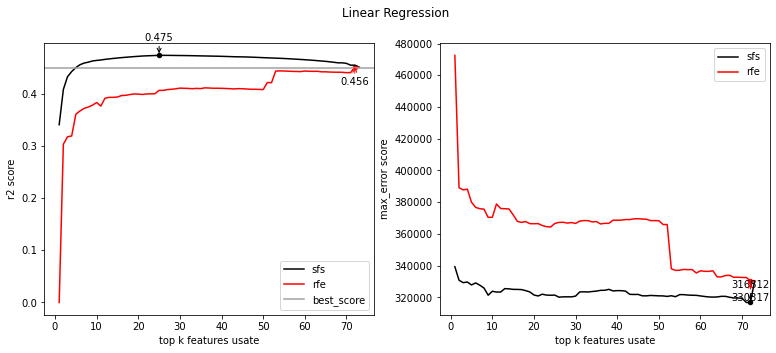

In [ ]:
model = LinearRegression()

feature_rank_sfs, cv_scores_sfs = sfs_analysis(model, X_data, Y_data)
feature_rank_rfe, cv_scores_rfe = rfe_analysis(model, X_data, Y_data)

plot_data(cv_scores_sfs, cv_scores_rfe, avg_score, "Linear Regression")


## Decision Tree

[====================] 73/73 forward selection.
[====================] 73/73 RFE

Best results:
	best scores sfs: (top features: 16, r2: 0.7809341383683224); (top features: 12, max_error: 177544.0)
	best scores rfe: (top features: 67, r2: 0.7733901377193981); (top features: 70, max_error: 266543.0)


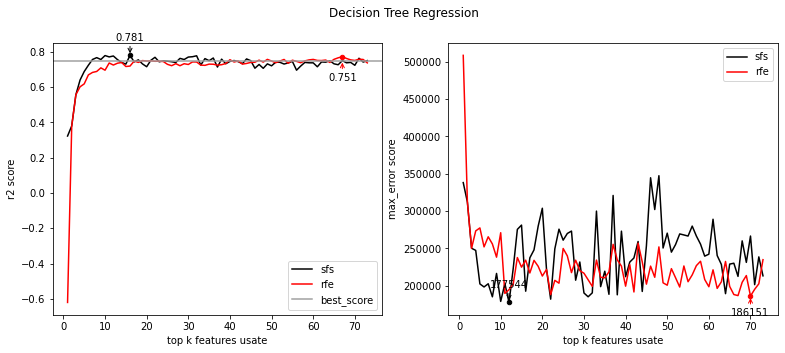

In [ ]:
model = DecisionTreeRegressor(max_depth=16, random_state=42)

feature_rank_sfs, cv_scores_sfs = sfs_analysis(model, X_data, Y_data)
feature_rank_rfe, cv_scores_rfe = rfe_analysis(model, X_data, Y_data)

plot_data(cv_scores_sfs, cv_scores_rfe, avg_score_dt, "Decision Tree Regression")

## Bagging

[====================] 73/73 forward selection.
[====================] 73/73 RFE

Best results:
	best scores sfs: (top features: 63, r2: 0.8671128287868083); (top features: 47, max_error: 188310.64099908815)
	best scores rfe: (top features: 60, r2: 0.8678349304060695); (top features: 52, max_error: 204385.0488888889)


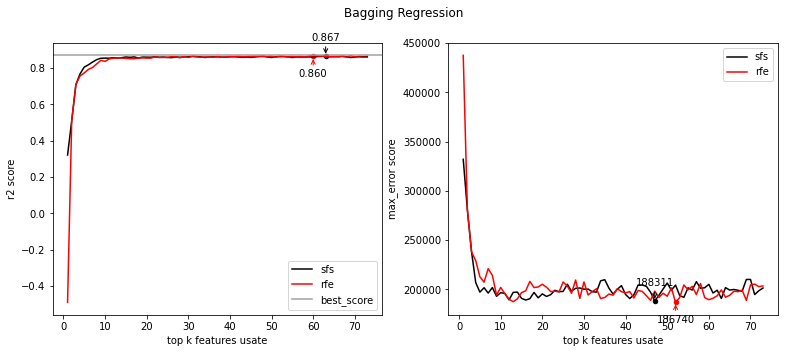

In [ ]:
model = BaggingRegressor(n_estimators=45, random_state=42)

feature_rank_sfs, cv_scores_sfs = sfs_analysis(model, X_data, Y_data)
feature_rank_rfe, cv_scores_rfe = rfe_analysis(model, X_data, Y_data)

plot_data(cv_scores_sfs, cv_scores_rfe, avg_score_bag_regr,"Bagging Regression")

## Gradient Boosting

[====================] 73/73 forward selection.
[====================] 73/73 RFE

Best results:
	best scores sfs: (top features: 51, r2: 0.8307063219149062); (top features: 15, max_error: 206020.3352697456)
	best scores rfe: (top features: 36, r2: 0.8344554746138229); (top features: 8, max_error: 216547.06388253244)


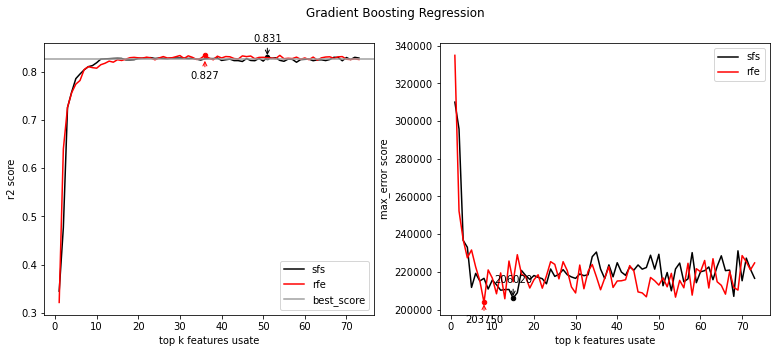

In [ ]:
model = GradientBoostingRegressor(random_state=42, n_estimators=50)

feature_rank_sfs, cv_scores_sfs = sfs_analysis(model, X_data, Y_data)
feature_rank_rfe, cv_scores_rfe = rfe_analysis(model, X_data, Y_data)

plot_data(cv_scores_sfs, cv_scores_rfe, avg_score_grad_regr, "Gradient Boosting Regression")

## Random Forest

[====================] 73/73 forward selection.
[====================] 73/73 RFE

Best results:
	best scores sfs: (top features: 31, r2: 0.8623655441363323); (top features: 31, max_error: 186866.792)
	best scores rfe: (top features: 44, r2: 0.8621579482406165); (top features: 21, max_error: 217403.04800000004)


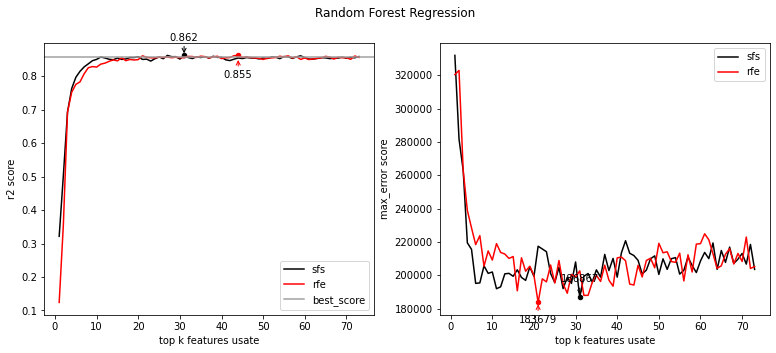

In [ ]:
model = RandomForestRegressor(random_state=42, n_estimators=25)

feature_rank_sfs, cv_scores_sfs = sfs_analysis(model, X_data, Y_data)
feature_rank_rfe, cv_scores_rfe = rfe_analysis(model, X_data, Y_data)

plot_data(cv_scores_sfs, cv_scores_rfe, avg_score_forest_regr, "Random Forest Regression")

## KNN

[====================] 73/73 forward selection.
[====================] 73/73 RFE

Best results:
	best scores sfs: (top features: 58, r2: 0.6888522309403885); (top features: 67, max_error: 221485.49687779113)
	best scores rfe: (top features: 5, r2: 0.6210916264183279); (top features: 5, max_error: 242427.8)


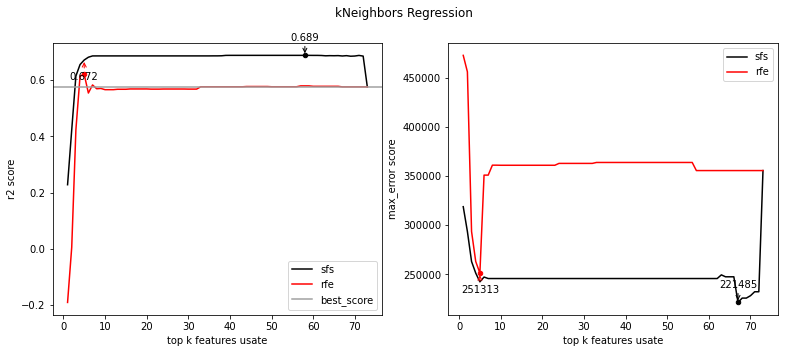

In [ ]:
model = KNeighborsRegressor(n_neighbors=5)

feature_rank_sfs, cv_scores_sfs = sfs_analysis(model, X_data, Y_data)
feature_rank_rfe, cv_scores_rfe = rfe_analysis(model, X_data, Y_data)

plot_data(cv_scores_sfs, cv_scores_rfe, avg_score_knn_regr, "kNeighbors Regression")

## Conclusioni

Di seguito vengono mostrate le differenze pre e post feature engineering dei modelli utilizzati:

| Model                        | Pre F.E.            | Post F.E. (sfs)     |
|------------------------------|---------------------|---------------------|
| Linear Regression (baseline) | 0.45884214917374083 | 0.47451116561430506 |
| Decision Tree                | 0.7326921869104969  | 0.7809341383683224  |
| Bagging                      | 0.8695609611655503  | 0.8671128287868083  |
| Gradient Boosting            | 0.8225499122620873  | 0.8307063219149062  |
| Random Forest                | 0.8579967940623094  | 0.8623655441363323  |
| KNN (non-parametric)         | 0.5746051789481946  | 0.6888522309403885  |

Per il nostro scopo vogliamo un modello che riesce a massimizzare lo score ottenuto sul dataset senza dare peso ad altri fattori. La nostra scelta è ricaduta su **Bagging** e **Random Forest** (rispettivamente utilizzando le top **63** e top **31** trovate utilizzando sfs) che sono i modelli che in media hanno ottenuto score migliore sia per r2 e per max_error.